In [2]:
root = '/content/drive/MyDrive/phototrap/'

In [3]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
!rm sample_rate
from google.colab import drive
drive.mount('/content/drive')

rm: cannot remove 'sample_rate': No such file or directory
Mounted at /content/drive


In [5]:
import pickle
import numpy as np
import pandas as pd
import random
from skimage import io
from sklearn.metrics import accuracy_score, roc_auc_score
import os
from glob import glob

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
import torch.utils.data
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

import torch.nn as nn

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [6]:
DEVICE = torch.device("cuda" if train_on_gpu else "cpu")
DEVICE

device(type='cuda')

# Setup

In [7]:
SIZE = 224

transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_aug = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.05, p=0.2),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),

    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
train_set = datasets.ImageFolder(root+'photo_traps_dataset/train', transform=transform_aug)
val_set = datasets.ImageFolder(root+'photo_traps_dataset/val', transform=transform)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=50, shuffle=False)

In [ ]:
print(len(train_set), len(val_set))

6033 820


# DINOv2


In [10]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 245MB/s]


In [11]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
        self.detach = True

    def forward(self, x):
        x = self.transformer(x)
        if self.detach:
            x = x.detach()
        x = self.classifier(x)
        return x

In [21]:
dino = DinoVisionTransformerClassifier().to(DEVICE)
dino.load_state_dict(torch.load(root+'dinov2_f4.pth', map_location=DEVICE))
dino.detach = False

In [22]:
epochs = 10
criteria = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(dino.parameters(), 1e-4)
tr_loss, val_loss = [], []
tr_acc, val_acc = [], []

In [23]:
# turn to fine-tuning from head-training
for g in opt.param_groups:
   g['lr'] = 1e-6
dino.detach = False

In [ ]:
for epoch in range(5, epochs):
    tl, vl, tm, vm = [], [], [], []

    # train round
    preds, targets = [], []
    dino.train()
    for X, y in tqdm(train_loader, leave=False):
        pred, target = dino(X.to(DEVICE)), y.to(DEVICE)

        l = criteria(pred, target)
        opt.zero_grad(); l.backward(); opt.step()
        tl.append(l.detach().cpu().item())
        preds.append(pred.detach().cpu())
        targets.append(target.detach().cpu())

    preds = torch.cat(preds, 0).numpy()
    targets = torch.cat(targets, 0).numpy()

    tl, tm = np.mean(tl), accuracy_score(targets, np.argmax(preds, 1))

    # val round
    preds, targets = [], []
    dino.eval()
    with torch.no_grad():
        for X, y in tqdm(val_loader, leave=False):
            pred, target = dino(X.to(DEVICE)), y.to(DEVICE)

            l = criteria(pred, target)
            vl.append(l.detach().cpu().item())

            preds.append(pred.detach().cpu())
            targets.append(target.detach().cpu())

    preds = torch.cat(preds, 0).numpy()
    targets = torch.cat(targets, 0).numpy()

    vl, vm = np.mean(vl), accuracy_score(targets, np.argmax(preds, 1))

    tr_loss.append(tl); val_loss.append(vl)
    tr_acc.append(tm); val_acc.append(vm)
    print(f'epoch {epoch}| loss = {tl:.4f} val_loss = {vl:.4f} | acc = {tm*100:.2f}%  val_acc = {vm*100:.2f}%')

    torch.save(dino.state_dict(), root+f'dinov2_f{epoch}.pth')

  4%|▍         | 5/121 [04:54<1:55:24, 59.69s/it]

In [ ]:
# история обучения (ранее предобучены дино и 5 эпох головы - метрики потеряны)
# epoch 0| loss = 0.2862 val_loss = 0.2063 | acc = 90.32%  val_acc = 93.78%
# epoch 1| loss = 0.1710 val_loss = 0.1722 | acc = 94.26%  val_acc = 94.76%
# epoch 2| loss = 0.1293 val_loss = 0.1555 | acc = 95.77%  val_acc = 94.76%
# epoch 3| loss = 0.1057 val_loss = 0.1539 | acc = 96.39%  val_acc = 95.61%
# epoch 4| loss = 0.0951 val_loss = 0.1476 | acc = 96.78%  val_acc = 95.37%

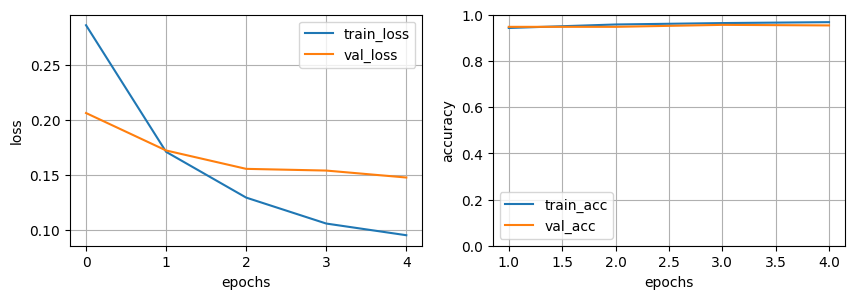

In [22]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.plot(tr_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(122)
plt.grid(True)
plt.plot(range(1, len(tr_acc)), tr_acc[1:], label="train_acc")
plt.plot(range(1, len(tr_acc)), val_acc[1:], label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0,1)

plt.show()

# Test

In [13]:
def pil_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        try:
            img = Image.open(f).convert("RGB")
        except:
            img = Image.new("RGB", (224, 224))
        return img

In [14]:
test_set = datasets.ImageFolder(root+'photo_traps_dataset/test', loader=pil_loader, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=16, shuffle=False)

In [17]:
dino.load_state_dict(torch.load(root+'dinov2_f3.pth', map_location=DEVICE))

<All keys matched successfully>

In [18]:
preds, targets = [], []
dino.eval()
with torch.no_grad():
    for X, y in tqdm(test_loader, leave=False):
        pred, target = dino(X.to(DEVICE)), y.to(DEVICE)
        preds.append(pred.detach().cpu())
        targets.append(target.detach().cpu())

preds = torch.cat(preds, 0)
targets = torch.cat(targets, 0).numpy()

print(accuracy_score(targets, np.argmax(preds.clone().detach().numpy(), 1)),
      roc_auc_score(targets, torch.softmax(torch.tensor(preds), 1).clone().detach().numpy(), multi_class='ovr'))

0.9548989113530326 0.9909499829844544


<ipython-input-18-0588f2685b29>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  roc_auc_score(targets, torch.softmax(torch.tensor(preds), 1).clone().detach().numpy(), multi_class='ovr'))


In [ ]:
# тестовые метрики:
# 3:  0.8631415241057543 0.9770387456743767
# 5:  0.9237947122861586 0.9805411254689033
# 7:  0.9206842923794712 0.9753164022193199
# после обогащения:
# f3: 0.9548989113530326 0.9909499829844544
# f4: 0.9611197511664075 0.9902319082743954


<Axes: >

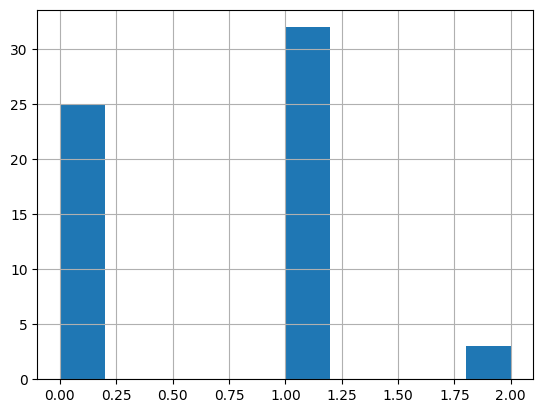

In [ ]:
df = pd.DataFrame(test_set.samples)
df[ df[1] != np.argmax(preds.clone().detach().numpy(), 1) ][1].hist()